In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data_parser

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:


def keypoints_to_dict(jaad_dict):
    ret_list = []
    for data in jaad_dict:
        keypoint_dict = {}
        pose_keypoints = data['pose_keypoints_2d']
        for i in range(0, len(pose_keypoints)-1, 3):
            keypoint_dict['x_' + str(i)] = pose_keypoints[i]
            keypoint_dict['y_' + str(i)] = pose_keypoints[i + 1]
        keypoint_dict['look'] = data['look']
        keypoint_dict['action'] = data['action']
        keypoint_dict['cross'] = data['cross']
        keypoint_dict['hand_gesture'] = data['hand_gesture']
        keypoint_dict['nod'] = data['nod']
        ret_list.append(keypoint_dict)
    return ret_list

def map_text_to_scalar(label_type, value):
        """
        Maps a text label in XML file to scalars
        :param label_type: The label type
        :param value: The text to be mapped
        :return: The scalar value
        """
        map_dic = {'occlusion': {'none': 0, 'part': 1, 'full': 2},
                   'action': {'standing': 0, 'walking': 1},
                   'nod': {'__undefined__': 0, 'nodding': 1},
                   'look': {'not-looking': 0, 'looking': 1},
                   'hand_gesture': {'__undefined__': 0, 'greet': 1, 'yield': 1,
                                    'rightofway': 1, 'other': 1},
                   'reaction': {'__undefined__': 0, 'clear_path': 1, 'speed_up': 2,
                                'slow_down': 3},
                   'cross': {'not-crossing': 0, 'crossing': 1, 'irrelevant': -1},
                   'age': {'child': 0, 'young': 1, 'adult': 2, 'senior': 3},
                   'designated': {'ND': 0, 'D': 1},
                   'gender': {'n/a': 0, 'female': 1, 'male': 2},
                   'intersection': {'no': 0, 'yes': 1},
                   'motion_direction': {'n/a': 0, 'LAT': 1, 'LONG': 2},
                   'traffic_direction': {'OW': 0, 'TW': 1},
                   'signalized': {'n/a': 0, 'NS': 1, 'S': 2},
                   'vehicle': {'stopped': 0, 'moving_slow': 1, 'moving_fast': 2,
                               'decelerating': 3, 'accelerating': 4},
                   'road_type': {'street': 0, 'parking_lot': 1, 'garage': 2},
                   'traffic_light': {'n/a': 0, 'red': 1, 'green': 2}}

        if type(value) is list or label_type not in map_dic:
            return value

        return map_dic[label_type][value]

# def convert_jaad_dict_to_df(jaad_dict):
#     updated_list = []
#     for j_dict in jaad_dict:
#         j_dict = {k: map_text_to_scalar(k, v) for k, v in j_dict.items()}
#         updated_list.append(j_dict)
#     data_dict = keypoints_to_dict(updated_list)
#     data = pd.DataFrame(data_dict)
#     data_y = data[['look', 'action', 'cross', 'hand_gesture', 'nod']]
#     data_x = data.drop(columns=['look', 'action', 'cross', 'hand_gesture', 'nod'])
#     df_norm = (data_x - data_x.mean()) / (data_x.max() - data_x.min())
#     return df_norm.astype('float'), data_y.astype('float')
#--------------update:------------------------------------------------------

def MinMaxScaling(data):
    scaler = MinMaxScaler()
    data=scaler.fit_transform(data)
    return data

def convert_jaad_dict_to_df(jaad_dict):
    updated_list = []
    for j_dict in jaad_dict:
        j_dict = {k: map_text_to_scalar(k, v) for k, v in j_dict.items()}
        updated_list.append(j_dict)
    data_dict = keypoints_to_dict(updated_list)
    data = pd.DataFrame(data_dict)
    data_y = data[['look', 'action', 'cross', 'hand_gesture', 'nod']]
    data_x = data.drop(columns=['look', 'action', 'cross', 'hand_gesture', 'nod'])
    # df_norm = (data_x - data_x.mean()) / (data_x.max() - data_x.min())
    df_norm = MinMaxScaling(data_x)
    return df_norm, data_y.astype('float')

def get_data(file_dir):
    """
    Will read JSON files from the provided file directory and subdirectories and return a list of dicts
    :param file_dir: directory where to look for input JSON files
    :return: list of dicts converted from JSON files
    """
    print('Starting to read JAAD json files!')
    json_list = []

    for dirpath, dirnames, filenames in os.walk(file_dir):
        JAAD_list = [pos_json for pos_json in filenames if pos_json.endswith('.json')]
        for js in JAAD_list:
            with open(os.path.join(dirpath, js)) as json_file:
                json_list.append(json.load(json_file))
    return json_list


def read_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return np.array(data)


def read_all_jsons(directory):
    # Read all files
    json_files = [f for f in os.listdir(directory) if f.endswith('.json')]

    # Create a new list
    all_data = []

    # Read all data from json-files
    for json_file in json_files:
        file_path = os.path.join(directory, json_file)
        data = read_json(file_path)
        all_data.append(data[:,:2])

    return np.array(all_data)

def read_all_folder(main_directory):
    arr = np.empty([0,25,2])
    for root, dirs, files in os.walk(main_directory):
        for dir_name in dirs:
            subdirectory_path = os.path.join(root, dir_name)
            arr = np.concatenate((arr,read_all_jsons(subdirectory_path)),axis=0)
    res = arr
    return res


# xml_to_dict

In [ ]:
import xml.etree.ElementTree as ET


def xml_to_dict(xml_string: str):
    root = ET.fromstring(xml_string)
    return element_to_dict(root)


def element_to_dict(element: ET.Element):
    result = {}
    if element.attrib:
        result.update(element.attrib)
    for child in element:
        child_data = element_to_dict(child)
        if child.tag in result:
            if not isinstance(result[child.tag], list):
                result[child.tag] = [result[child.tag]]
            result[child.tag].append(child_data)
        else:
            result[child.tag] = child_data
    if element.text:
        result[element.tag] = element.text.strip()
    return result


if __name__ == "__main__":
    # Example XML string
    xml_string = '''
    <annotations>
        <version>1.1</version>
        <meta>
            <task>
            </task>
            <dumped>2019-02-18 20:02:59.930671+03:00</dumped>
        </meta>
        <track label="pedestrian">
            <box frame="0" keyframe="1" occluded="0" outside="0" xbr="533.0" xtl="465.0" ybr="848.0" ytl="730.0">
                <attribute name="id">0_1_3b</attribute>
                <attribute name="old_id">pedestrian1</attribute>
                <attribute name="look">not-looking</attribute>
                <attribute name="reaction">__undefined__</attribute>
                <attribute name="action">standing</attribute>
                <attribute name="cross">not-crossing</attribute>
                <attribute name="hand_gesture">__undefined__</attribute>
                <attribute name="occlusion">none</attribute>
                <attribute name="nod">__undefined__</attribute>
            </box>
            <box frame="1" keyframe="1" occluded="0" outside="0" xbr="532.0" xtl="463.0" ybr="848.0" ytl="730.0">
                <attribute name="id">0_1_3b</attribute>
                <attribute name="old_id">pedestrian1</attribute>
                <attribute name="look">not-looking</attribute>
                <attribute name="reaction">__undefined__</attribute>
                <attribute name="action">standing</attribute>
                <attribute name="cross">not-crossing</attribute>
                <attribute name="hand_gesture">__undefined__</attribute>
                <attribute name="occlusion">none</attribute>
                <attribute name="nod">__undefined__</attribute>
            </box>
            <box frame="2" keyframe="1" occluded="0" outside="0" xbr="531.0" xtl="461.0" ybr="849.0" ytl="730.0">
                <attribute name="id">0_1_3b</attribute>
                <attribute name="old_id">pedestrian1</attribute>
                <attribute name="look">not-looking</attribute>
                <attribute name="reaction">__undefined__</attribute>
                <attribute name="action">standing</attribute>
                <attribute name="cross">not-crossing</attribute>
                <attribute name="hand_gesture">__undefined__</attribute>
                <attribute name="occlusion">none</attribute>
                <attribute name="nod">__undefined__</attribute>
            </box>
        </track>
    </annotations>
    '''

    xml_string_short = '''
        <annotations>
            <version>1.1</version>
            <meta></meta>
            <track label="pedestrian">
            </track>
            <track label="ped">
            </track>
            <track label="pedestrian">
            </track>
            <track label="ped">
            </track>
        </annotations>
        '''

    # Convert XML to dictionary
    xml_dict = xml_to_dict(xml_string)
    print(xml_dict)


{'version': {'version': '1.1'}, 'meta': {'task': {'task': ''}, 'dumped': {'dumped': '2019-02-18 20:02:59.930671+03:00'}, 'meta': ''}, 'track': {'label': 'pedestrian', 'box': [{'frame': '0', 'keyframe': '1', 'occluded': '0', 'outside': '0', 'xbr': '533.0', 'xtl': '465.0', 'ybr': '848.0', 'ytl': '730.0', 'attribute': [{'name': 'id', 'attribute': '0_1_3b'}, {'name': 'old_id', 'attribute': 'pedestrian1'}, {'name': 'look', 'attribute': 'not-looking'}, {'name': 'reaction', 'attribute': '__undefined__'}, {'name': 'action', 'attribute': 'standing'}, {'name': 'cross', 'attribute': 'not-crossing'}, {'name': 'hand_gesture', 'attribute': '__undefined__'}, {'name': 'occlusion', 'attribute': 'none'}, {'name': 'nod', 'attribute': '__undefined__'}], 'box': ''}, {'frame': '1', 'keyframe': '1', 'occluded': '0', 'outside': '0', 'xbr': '532.0', 'xtl': '463.0', 'ybr': '848.0', 'ytl': '730.0', 'attribute': [{'name': 'id', 'attribute': '0_1_3b'}, {'name': 'old_id', 'attribute': 'pedestrian1'}, {'name': 'look

# Merge_jaad_with_labels

In [ ]:
import csv
import math
import os
import json
import re

# from model.action_recognition.scripts.xml_to_dict import xml_to_dict

# from xml_to_dict import xml_to_dict

from pathlib import Path


def infer_frame_number(filename: str):
    pattern = r'.*_(\d{12})_.*'  # Assuming frame number is always 12 digits
    match = re.match(pattern, filename)
    if match:
        frame_number = match.group(1)
        return int(frame_number)
    else:
        raise ValueError('Invalid file name format. Cannot infer frame number.')


def read_xml_file(path: str):
    # Reading the data inside the xml
    # file to a variable under the name
    # data
    with open(path, 'r') as f:
        data = f.read()
    return data


def get_pedestrians_from_dict(annotations: dict):
    if 'track' not in annotations:
        return {}
    tracks = annotations['track']
    pedestrians = {}
    if type(tracks) is list:
        for track in tracks:
            label = track['label']
            if label == "pedestrian":
                boxes = track['box']
                first_frame_for_box = boxes[0]
                attributes = first_frame_for_box['attribute']
                pedestrian_id = attributes[0]['attribute']
                pedestrians[pedestrian_id] = track
    else:
        label = tracks['label']
        if label == "pedestrian":
            boxes = tracks['box']
            first_frame_for_box = boxes[0]
            attributes = first_frame_for_box['attribute']
            pedestrian_id = attributes[0]['attribute']
            pedestrians[pedestrian_id] = tracks

    return pedestrians


def get_pedestrian_labels_from_frame(pedestrian: dict, frame_number: int):
    for frame_infos in pedestrian['box']:
        if frame_number == int(frame_infos['frame']):
            return frame_infos['attribute']
    raise Exception("Frame number not found")


def check_if_in_box(data, box):
    xbr = float(box['xbr'])
    xtl = float(box['xtl'])
    ybr = float(box['ybr'])
    ytl = float(box['ytl'])
    person_list = []
    for person in data['people']:
        keypoints = person['pose_keypoints_2d']
        i = 0
        j = 1
        number_of_hits = 0
        for z in range(len(keypoints)):
            if i == len(keypoints):
                break
            xp = keypoints[i]
            yp = keypoints[j]
            if xtl <= xp and xp <= xbr and ytl <=yp and yp <= ybr :
                number_of_hits +=1
            i += 3
            j += 3
        person_list.append(number_of_hits)
    max_value = max(person_list)
    index = person_list.index(max_value)
    found_pedestrian = data['people'][index]
    return found_pedestrian


def attributes_to_dict(person_in_box, attribute_list):
    attribute_dict = {}
    for attribute in attribute_list:
        person_in_box[attribute['name']] = attribute['attribute']
    return attribute_dict


def merge_jaad_with_labels(data: dict, box):
    person_in_box = check_if_in_box(data, box)
    person_in_box['attributes'] = attributes_to_dict(person_in_box, box['attribute'])
    return person_in_box



def save_data(update_data: dict, output_folder: str, filename: str):
    path = output_folder / filename
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as outfile:
        json.dump(update_data, outfile)


if __name__ == "__main__":
    filenames_without_ending = ['video_0173', 'video_0304', 'video_0276', 'video_0083', 'video_0021', 'video_0328',
                                'video_0255', 'video_0185', 'video_0097', 'video_0273', 'video_0090', 'video_0162',
                                'video_0227', 'video_0260', 'video_0272', 'video_0287', 'video_0186', 'video_0126',
                                'video_0230', 'video_0140', 'video_0037', 'video_0289', 'video_0341', 'video_0085',
                                'video_0010', 'video_0232', 'video_0284', 'video_0222', 'video_0137', 'video_0158',
                                'video_0079', 'video_0169', 'video_0038', 'video_0292', 'video_0280', 'video_0246',
                                'video_0256', 'video_0229', 'video_0239', 'video_0011', 'video_0243', 'video_0312',
                                'video_0261', 'video_0160', 'video_0271', 'video_0004', 'video_0241', 'video_0088',
                                'video_0316', 'video_0045', 'video_0017', 'video_0337', 'video_0339', 'video_0167',
                                'video_0023', 'video_0262', 'video_0054', 'video_0192', 'video_0008', 'video_0319',
                                'video_0056', 'video_0238', 'video_0170', 'video_0009', 'video_0073', 'video_0285',
                                'video_0042', 'video_0030', 'video_0108', 'video_0198', 'video_0268', 'video_0176',
                                'video_0046', 'video_0300', 'video_0096', 'video_0070', 'video_0047', 'video_0254',
                                'video_0265', 'video_0248', 'video_0035', 'video_0205', 'video_0195', 'video_0166',
                                'video_0193', 'video_0275', 'video_0050', 'video_0207', 'video_0041', 'video_0091',
                                'video_0322', 'video_0329', 'video_0294', 'video_0003', 'video_0044', 'video_0104',
                                'video_0318', 'video_0118', 'video_0163', 'video_0161', 'video_0032', 'video_0252',
                                'video_0197', 'video_0086', 'video_0102', 'video_0120', 'video_0084', 'video_0129',
                                'video_0068', 'video_0168', 'video_0217', 'video_0308', 'video_0333', 'video_0024',
                                'video_0288', 'video_0007', 'video_0259', 'video_0060', 'video_0066', 'video_0211',
                                'video_0123', 'video_0321', 'video_0101', 'video_0012', 'video_0115', 'video_0212',
                                'video_0027', 'video_0100', 'video_0155', 'video_0082', 'video_0107', 'video_0315',
                                'video_0057', 'video_0099', 'video_0295', 'video_0048', 'video_0286', 'video_0218',
                                'video_0061', 'video_0346', 'video_0014', 'video_0181', 'video_0196']



    video_files = [f + ".mp4" for f in filenames_without_ending]
    annotation_files = [f + ".xml" for f in filenames_without_ending]

    # dir_jaad = Path("C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/JAAD_output_JSON")
    # path_labels = Path("C:/Users/max00/Downloads/JAAD-JAAD_2.0/JAAD-JAAD_2.0/annotations/")
    # output_folder = Path("C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/JAAD_JSON_Labels/")
    # dir_jaad = Path("C:/Users/HP/Desktop/APP-RAS/pedestrian-pose-recognition-action_recognition/pedestrian-pose-recognition-action_recognition/data/JAAD_output_JSON")
    # path_labels = Path("D:/APP-RAS/annotations/annotations")
    # output_folder = Path("D:/APP-RAS/JAADLabels/")
    # pedestrian_new = []
    # # print(path_labels)
    # for video_name in os.listdir(dir_jaad):
    #     # print(video_name)
    #     # print(path_labels/(video_name+'.xml'))
    #     annotation_file = path_labels / (video_name + ".xml")
    #     # print(type(annotation_file))
    #     # annotation_file = r"{}".format(annotation_file)
    #     # print(type(annotation_file))
    #     # print(str(annotation_file))
    #     annotations = xml_to_dict(read_xml_file(str(annotation_file)))
    #     annotations = xml_to_dict(read_xml_file(annotation_file))
    #     pedestrians = get_pedestrians_from_dict(annotations)
    #     for pedestrian in pedestrians.values():
    #         for box in pedestrian['box']:
    #             frame = box['frame']
    #             json_file = video_name + "_" + frame.zfill(12) + "_" + 'keypoints' + ".json"
    #             f = open(dir_jaad / video_name / json_file)
    #             data = json.load(f)
    #             if len(data['people']) == 0:
    #                 continue
    #             p_new = merge_jaad_with_labels(data, box)
    #             pedestrian_new.append(p_new)
    #             save_data(p_new, output_folder / video_name, json_file)

    # a = xml_to_dict("D:/APP-RAS/annotations/annotations/video_0328.xml")
# a = "D:\APP-RAS\annotations\annotations\video_0083.xml"
# anno = read_xml_file(r"D:\APP-RAS\annotations\annotations\video_0083.xml")
# anno = read_xml_file("D:\\APP-RAS\\annotations\\annotations\\video_0083.xml")

# print(anno)
# annotations = xml_to_dict(read_xml_file("D:\\APP-RAS\\annotations\\annotations\\video_0329.xml"))
# print(annotations)
# print(annotation_file)


# D=read_xml_file("D:/APP-RAS/annotations/annotations/video_0328.xml")
# with open("D:/APP-RAS/annotations/annotations/video_0328.xml", 'r') as f:
#     data = f.read()
# print(D==data)

# Graph

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

(25, 25)


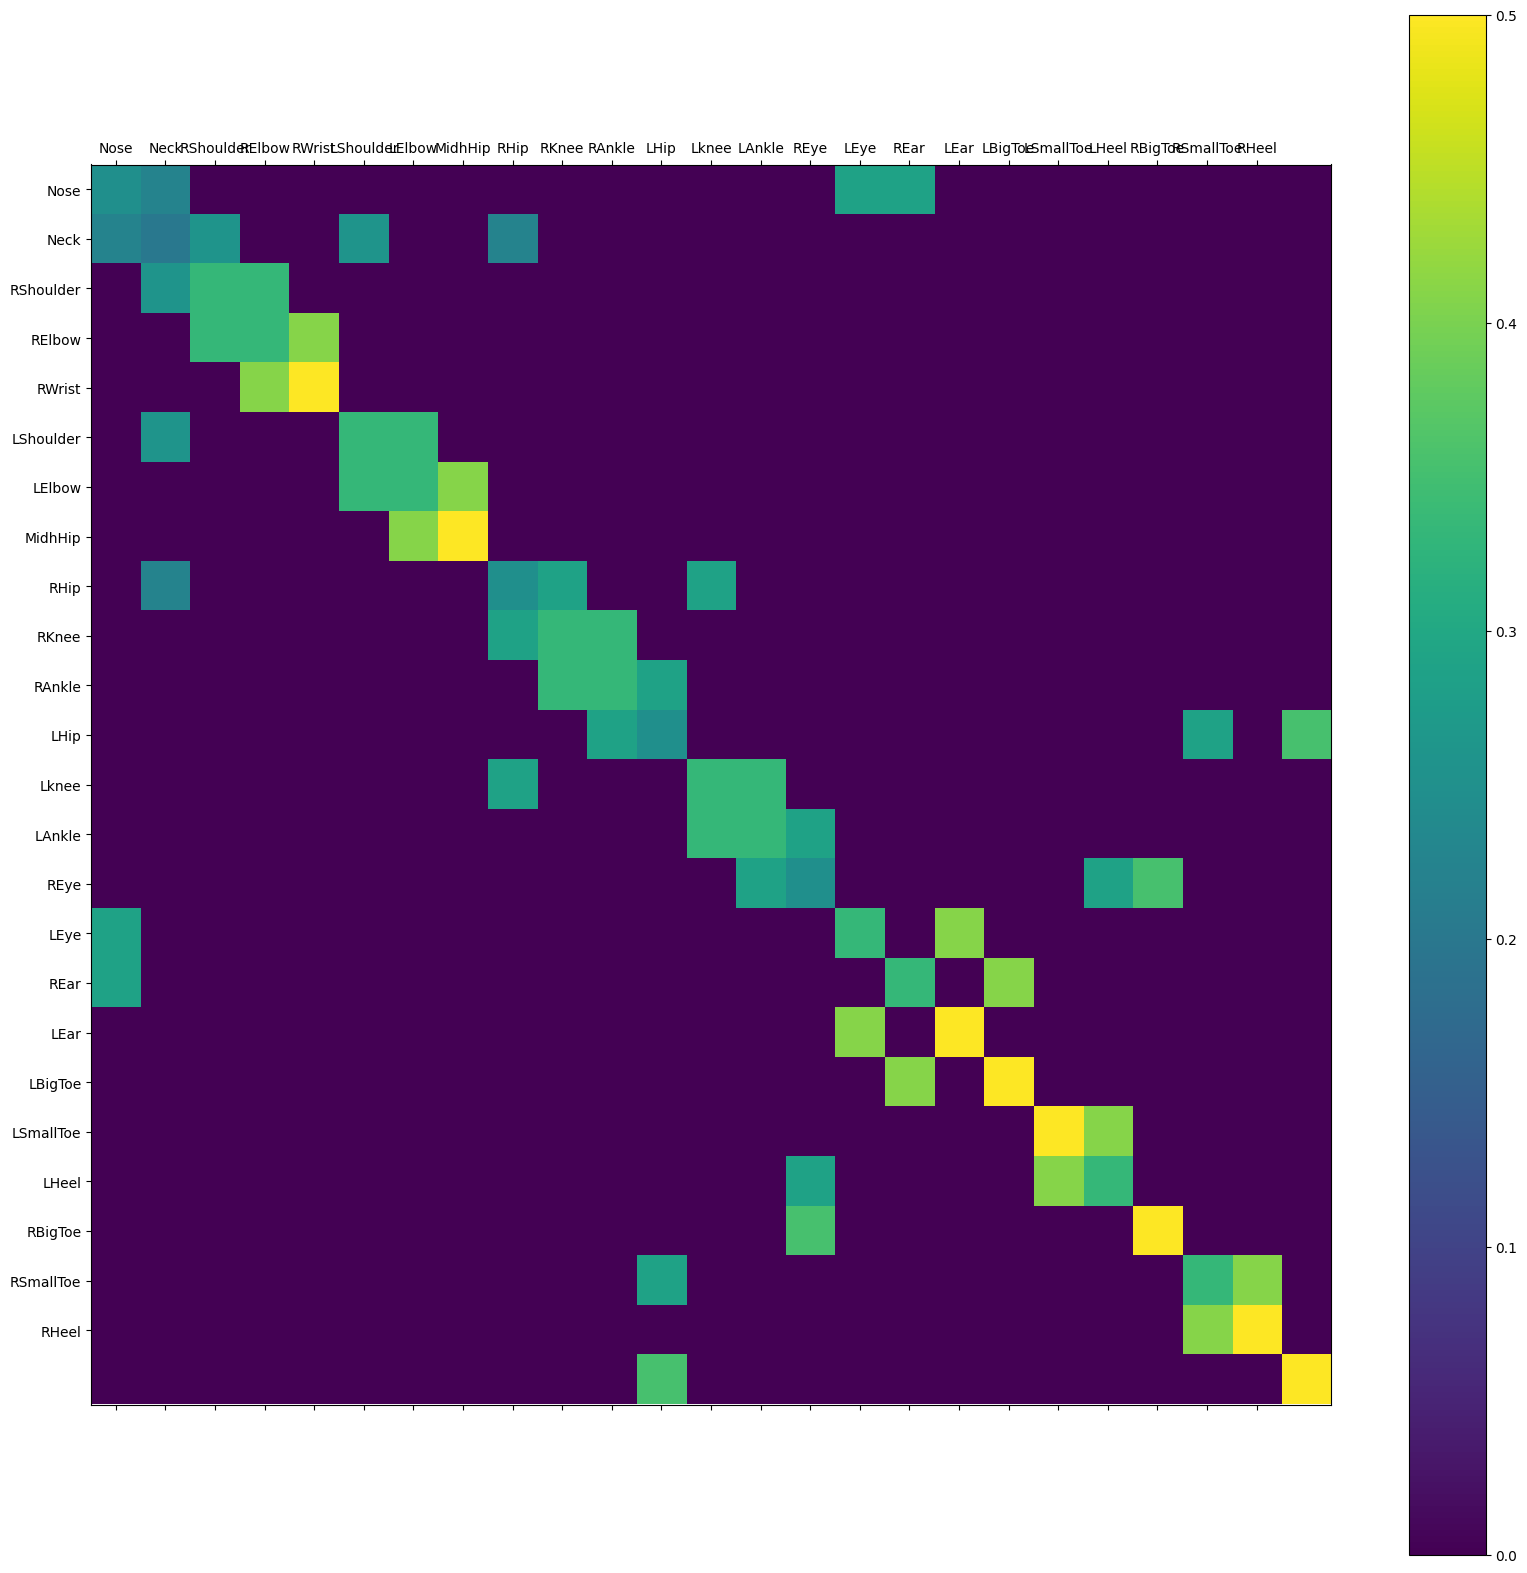

In [ ]:


class Graph():


    def __init__(self,
                 layout='jaad',
                 strategy='uniform',
                 max_hop=1,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge(layout)
        self.hop_dis = get_hop_distance(self.num_node, self.edge, max_hop=max_hop)
        self.get_adjacency(strategy)

    def __str__(self):
        return self.A

    def get_edge(self, layout):
        if layout == 'jaad':
            self.num_node = 25
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_1base = [(0, 1), (0, 15), (0, 16), (1, 2), (1, 5),
                              (1, 8), (5, 6), (6, 7), (2, 3), (3, 4),
                              (12, 13), (13, 14), (9, 10), (10, 11), (8, 9),
                              (8, 12), (14, 21), (11, 24), (14, 20), (20, 19),
                              (11, 22), (22, 23), (16, 18), (15, 17)]
            neighbor_link = [(i, j) for (i, j) in neighbor_1base]
            self.edge = self_link + neighbor_link
            self.center = 21 - 1
        else:
            raise ValueError("Don't exist this layout")

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_undigraph(adjacency)

        if strategy == 'uniform':
            A = np.zeros((1, self.num_node, self.num_node))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == 'distance':
            A = np.zeros((len(valid_hop), self.num_node, self.num_node))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
            self.A = A
        elif strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if self.hop_dis[j, self.center] == self.hop_dis[i, self.center]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.hop_dis[j, self.center] > self.hop_dis[i, self.center]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
        else:
            raise ValueError("Do Not Exist This Strategy")

def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis



def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i] ** (-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD


graph = Graph()
Adjacency_matrix = graph.A
Adjacency_matrix_show = Adjacency_matrix.reshape((25,25))
print(Adjacency_matrix_show.shape)

# Plot adjacency_matrix
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
alpha = ['Nose', 'Neck', 'RShoulder', 'RElbow','RWrist','LShoulder','LElbow','MidhHip',"RHip","RKnee","RAnkle","LHip",'Lknee','LAnkle','REye',"LEye","REar","LEar","LBigToe","LSmallToe","LHeel","RBigToe","RSmallToe","RHeel"]
cax = ax.matshow(Adjacency_matrix_show)
fig.colorbar(cax)
ax.set_xticks(np.arange(len(alpha)), labels=alpha)
ax.set_yticks(np.arange(len(alpha)), labels=alpha)
plt.show()

# ConvTemporalGraphical

In [ ]:
import torch
import torch.nn as nn
import math
# from Graph import Graph

In [ ]:
class ConvTemporalGraphical(nn.Module):
    # Source : https://github.com/yysijie/st-gcn/blob/master/net/st_gcn.py
    """The basic module for applying a graph convolution.
    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int): Size of the graph convolving kernel
        t_kernel_size (int): Size of the temporal convolving kernel
        t_stride (int, optional): Stride of the temporal convolution. Default: 1
        t_padding (int, optional): Temporal zero-padding added to both sides of
            the input. Default: 0
        t_dilation (int, optional): Spacing between temporal kernel elements.
            Default: 1
        bias (bool, optional): If ``True``, adds a learnable bias to the output.
            Default: ``True``
    Shape:
        - Input: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Output: Outpu graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
    """

    def __init__(self,
                 time_dim,
                 joints_dim
                 ):
        super(ConvTemporalGraphical, self).__init__()

        graph = Graph()
        self.A = nn.Parameter(torch.FloatTensor(graph.A))
        stdv = 1. / math.sqrt(self.A.size(1))
        self.A.data.uniform_(-stdv, stdv)

        self.T = nn.Parameter(torch.FloatTensor(joints_dim, time_dim, time_dim))
        stdv = 1. / math.sqrt(self.T.size(1))
        self.T.data.uniform_(-stdv, stdv)
        '''
        self.prelu = nn.PReLU()

        self.Z=nn.Parameter(torch.FloatTensor(joints_dim, joints_dim, time_dim, time_dim))
        stdv = 1. / math.sqrt(self.Z.size(2))
        self.Z.data.uniform_(-stdv,stdv)
        '''

    def forward(self, x, A):
        x = torch.einsum('ncvt,vtq->ncqv', (x, self.T))
        ## x=self.prelu(x)
        x = torch.einsum('nctv,tvw->nctw', (x, self.A))
        ## x = torch.einsum('nctv,wvtq->ncqw', (x, self.Z))
        return x.contiguous()

# ST_GCN

In [ ]:
# import tcn
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import AdamW
# from data_parser import convert_jaad_dict_to_df, get_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
# from keras-tcn import TCN, tcn_full_summary
from keras.layers import Dense
from keras.models import Sequential
from torch.autograd import Variable

In [ ]:
class st_gcn(nn.Module):
    """
    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Outpu graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
            :in_channels= dimension of coordinates
            : out_channels=dimension of coordinates
            +
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 time_dim=1,
                 joints_dim=25,
                 dropout=0,
                 bias=True):

        super(st_gcn, self).__init__()
        self.kernel_size = kernel_size
        assert self.kernel_size[0] % 2 == 1
        assert self.kernel_size[1] % 2 == 1
        padding = ((self.kernel_size[0] - 1) // 2, (self.kernel_size[1] - 1) // 2)
        self.gcn = ConvTemporalGraphical(time_dim, joints_dim)  # the convolution layer
        self.tcn = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                (self.kernel_size[0], self.kernel_size[1]),
                (stride, stride),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        if stride != 1 or in_channels != out_channels:

            self.residual = nn.Sequential(nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=(1, 1)),
                nn.BatchNorm2d(out_channels),
            )


        else:
            self.residual = nn.Identity()

        self.prelu = nn.PReLU()

    def forward(self, x, A):
        #   assert A.shape[0] == self.kernel_size[1], print(A.shape[0],self.kernel_size)
        res = self.residual(x)
        x = self.gcn(x, A)
        x = x.permute(0,1,3,2)
        x = self.tcn(x) + res
        x = self.prelu(x)
        return x, A

In [ ]:
class CNN_layer(
    nn.Module):
    # This is the simple CNN layer,that performs a 2-D convolution while maintaining the dimensions of the input(except for the features dimension)

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 dropout,
                 bias=True):
        super(CNN_layer, self).__init__()
        self.kernel_size = kernel_size
        padding = (
        (kernel_size[0] - 1) // 2, (kernel_size[1] - 1) // 2)  # padding so that both dimensions are maintained
        assert kernel_size[0] % 2 == 1 and kernel_size[1] % 2 == 1

        self.block = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
            , nn.BatchNorm2d(out_channels), nn.Dropout(dropout, inplace=True)]

        self.block = nn.Sequential(*self.block)

    def forward(self, x):
        output = self.block(x)
        return output

In [ ]:
class PedestrianGraphNetwork(nn.Module):
    def __init__(self, kernel_size):
        super(PedestrianGraphNetwork,self).__init__()
        self.st_gcn = nn.ModuleList()
        self.txcnns = nn.ModuleList()
        self.st_gcn.append(st_gcn(1, 64, kernel_size))
        self.st_gcn.append(st_gcn(64,32, kernel_size))
        self.st_gcn.append(st_gcn(32,64,kernel_size))
        # at this point, we must permute the dimensions of the gcn network, from (N,C,T,V) into (N,T,C,V)
        self.txcnns.append(CNN_layer(64,32,kernel_size,dropout=0.5)) # with kernel_size[3,3] the dimensinons of C,V will be maintained
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(32, 1)
        # self.fc = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.bn = nn.BatchNorm1d(32)
        self.adjacency_matrix = torch.tensor(Graph().A, dtype=torch.float32)
    def forward(self, x):
        for gcn in (self.st_gcn):
            x,_ = gcn(x,self.adjacency_matrix)

        for tcnn in (self.txcnns):
            x = tcnn(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.bn(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


1.JAAD dataset

In [ ]:
if __name__ == '__main__':

    data_dir = '/content/drive/My Drive/JAAD_per_person/'
    lst = get_data((data_dir))
    X, Y = convert_jaad_dict_to_df(get_data(data_dir))
    Y = Y.drop(columns=['cross'])

Starting to read JAAD json files!
Starting to read JAAD json files!


2.KTH dataset

In [ ]:
handwaving = "/content/drive/My Drive/data/handwaving"
handclipping = "/content/drive/My Drive/data/handclipping"
arr_handwaving = read_all_folder(handwaving)
arr_handclipping = read_all_folder(handclipping)
data_hw = [arr_handwaving[i].flatten() for i in range(arr_handwaving.shape[0])]
data_hc = [arr_handclipping[i].flatten() for i in range(arr_handclipping.shape[0])]
data_hand = data_hw + data_hc
df_hand = pd.DataFrame(data_hand)
scaler = MinMaxScaler()
scaler.fit(df_hand)
arr_hand = scaler.transform(df_hand)
label_array = np.array([1, 0, 1, 0])
label_df = pd.DataFrame(np.tile(label_array,(len(data_hand), 1)), columns=['look', 'action', 'hand_gesture', 'nod'])

In [ ]:
X = pd.concat([pd.DataFrame(X), pd.DataFrame(arr_hand)], ignore_index=True)
X = X.values
Y = pd.concat([Y,label_df], ignore_index=True)

In [ ]:
feature_matrix = X.reshape(-1, 25, 2)
feature_matrix = torch.tensor(feature_matrix, dtype=torch.float32)
expanded_X = torch.unsqueeze(feature_matrix, 1)
labels = Y


X_train, X_test, y_train, y_test = train_test_split(expanded_X, labels, test_size=0.4, random_state=42)
X_train = torch.tensor(X_train.clone(), dtype=torch.float32)
X_test = torch.tensor(X_test.clone(), dtype=torch.float32)


<ipython-input-23-2d232bded319>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train.clone(), dtype=torch.float32)
<ipython-input-23-2d232bded319>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test.clone(), dtype=torch.float32)


look


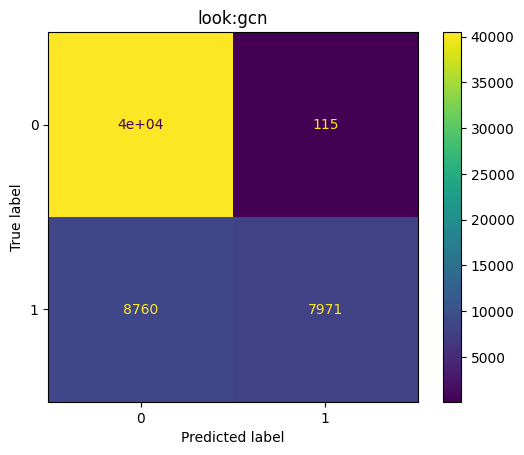

Test Accuracy: 84.52%
F1_score: 64.24%
action


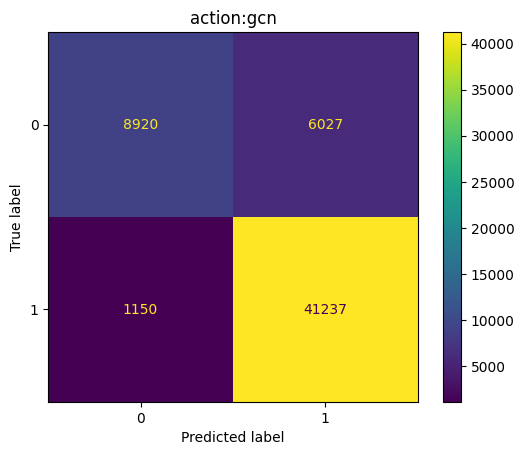

Test Accuracy: 87.48%
F1_score: 91.99%
hand_gesture


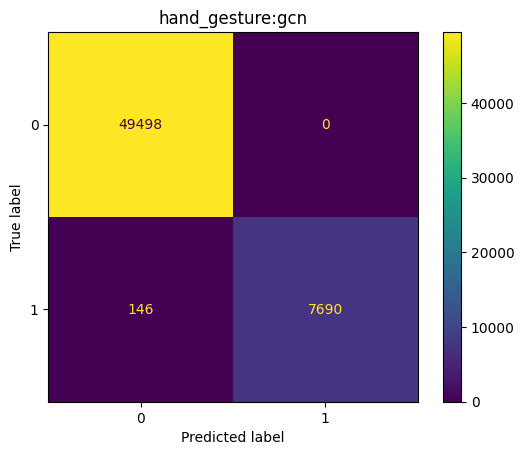

Test Accuracy: 99.75%
F1_score: 99.06%
nod


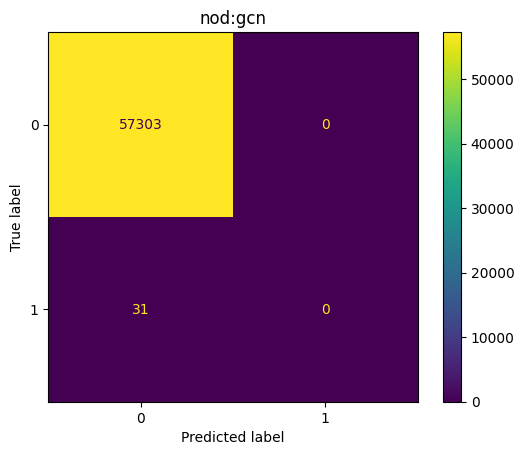

Test Accuracy: 99.95%
F1_score: 0.00%


In [ ]:
for col in y_train.columns:
    model = PedestrianGraphNetwork(tuple([3,3]))
    Y_train = torch.tensor(y_train[col].values, dtype=torch.float)
    # print("Y_train:",Y_train.shape)
    Y_test = torch.tensor(y_test[col].values, dtype=torch.float)
    print(col)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=0.001)
    num_epochs = 30
    batch_size = 64
    Xtrain_loader = DataLoader(X_train, batch_size=batch_size, shuffle=False)
    Ytrain_loader = DataLoader(Y_train, batch_size=batch_size, shuffle=False)
    model.train()
    for epoch in range(num_epochs):
        for batch1, batch2 in zip(Xtrain_loader,Ytrain_loader):
            optimizer.zero_grad()
            outputs = model(batch1)
            loss = F.binary_cross_entropy_with_logits(outputs, batch2[:, None], weight=None)
            loss.backward()
            optimizer.step()
    model.eval()
    Xtest_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
    Ytest_loader = DataLoader(Y_test, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        test_accuracy = 0.0
        num_test_samples = 0
        y_true = []
        y_pred = []
        for batch1, batch2 in zip(Xtest_loader, Ytest_loader):
            outputs = model(batch1)
            outputs = torch.where(outputs >= 0.5, torch.tensor(1), torch.tensor(0))
            y_true.extend(batch2.tolist())
            y_pred.extend(outputs.squeeze().tolist())
            test_accuracy += (outputs == batch2[:, None]).sum().item()
            num_test_samples += batch2.size(0)
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        TN = np.sum((y_pred == 0) & (y_true == 0))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        precision = TP / (TP+FP) if (TP+FP) != 0 else 0
        recall = TP / (TP+FN) if (TP+FN) != 0 else 0
        f1_score = (2*(precision*recall))/(precision+recall) if (precision+recall) != 0 else 0
        conf_mat = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
        disp.plot()
        plt.title(col+':gcn')
        plt.show()
        test_accuracy /= num_test_samples
        print('Test Accuracy: {:.2f}%'.format(test_accuracy * 100))
        print('F1_score: {:.2f}%'.format(f1_score*100))


In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


look


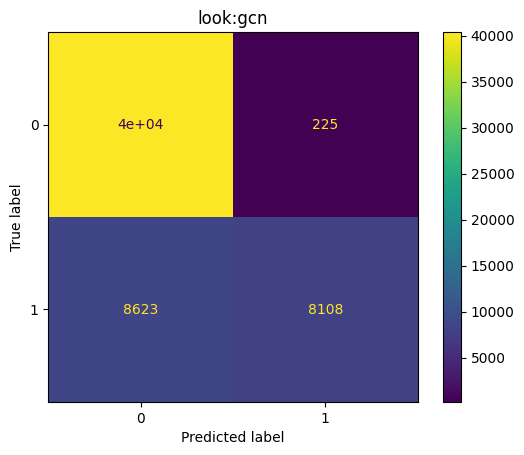

Test Accuracy: 84.57%
F1_score: 64.70%
action


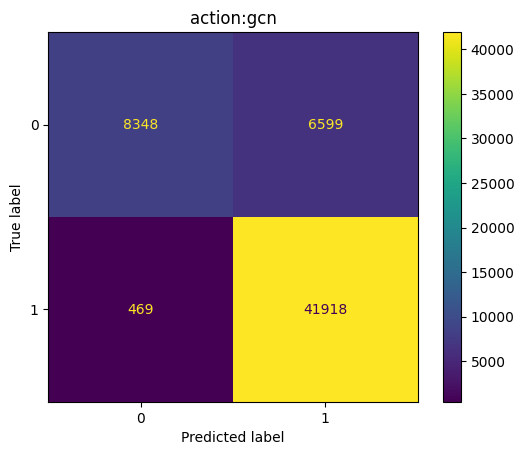

Test Accuracy: 87.67%
F1_score: 92.22%
hand_gesture


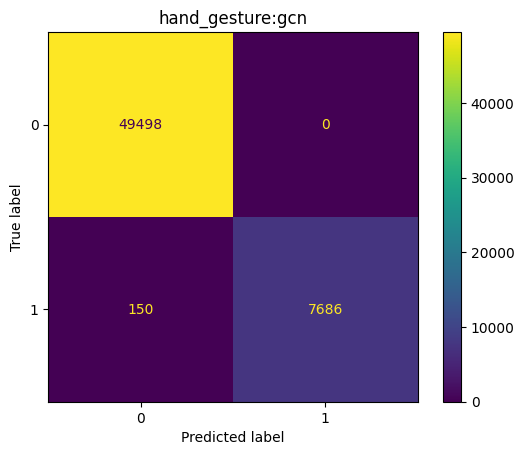

Test Accuracy: 99.74%
F1_score: 99.03%
nod


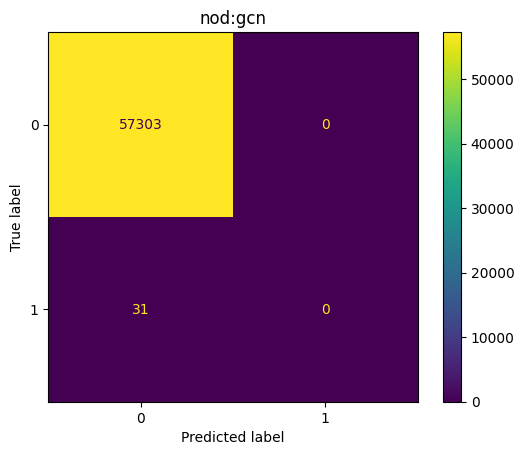

Test Accuracy: 99.95%
F1_score: 0.00%


In [ ]:
for col in y_train.columns:
    model = PedestrianGraphNetwork(tuple([3,3]))
    Y_train = torch.tensor(y_train[col].values, dtype=torch.float)
    # print("Y_train:",Y_train.shape)
    Y_test = torch.tensor(y_test[col].values, dtype=torch.float)
    print(col)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=0.001)
    num_epochs = 30
    batch_size = 64
    Xtrain_loader = DataLoader(X_train, batch_size=batch_size, shuffle=False)
    Ytrain_loader = DataLoader(Y_train, batch_size=batch_size, shuffle=False)
    model.train()
    for epoch in range(num_epochs):
        for batch1, batch2 in zip(Xtrain_loader,Ytrain_loader):
            optimizer.zero_grad()
            outputs = model(batch1)
            loss = F.binary_cross_entropy_with_logits(outputs, batch2[:, None], weight=None)
            loss.backward()
            optimizer.step()
    model.eval()
    Xtest_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
    Ytest_loader = DataLoader(Y_test, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        test_accuracy = 0.0
        num_test_samples = 0
        y_true = []
        y_pred = []
        for batch1, batch2 in zip(Xtest_loader, Ytest_loader):
            outputs = model(batch1)
            outputs = torch.where(outputs >= 0.6, torch.tensor(1), torch.tensor(0))
            y_true.extend(batch2.tolist())
            y_pred.extend(outputs.squeeze().tolist())
            test_accuracy += (outputs == batch2[:, None]).sum().item()
            num_test_samples += batch2.size(0)
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        TN = np.sum((y_pred == 0) & (y_true == 0))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        precision = TP / (TP+FP) if (TP+FP) != 0 else 0
        recall = TP / (TP+FN) if (TP+FN) != 0 else 0
        f1_score = (2*(precision*recall))/(precision+recall) if (precision+recall) != 0 else 0
        conf_mat = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
        disp.plot()
        plt.title(col+':gcn')
        plt.show()
        test_accuracy /= num_test_samples
        print('Test Accuracy: {:.2f}%'.format(test_accuracy * 100))
        print('F1_score: {:.2f}%'.format(f1_score*100))